In [2]:
import xarray as xr
import numpy as np
import zarr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
from matplotlib.colors import BoundaryNorm
import pandas as pd
import cmocean
import seaborn as sns

from datetime import timedelta 
from parcels import AdvectionRK4, AdvectionRK45, Variable, Field, FieldSet, JITParticle, ScipyParticle, ParticleFile, ParticleSet, kernel, StatusCode

%matplotlib ipympl

In [3]:
ds = xr.load_dataset('/Users/jordan/Documents/CICOES/data/cape_large_00.nc', decode_times = False)

In [4]:
#ds = ds.where(((ds.x_rho > -1000) & (ds.x_rho < 1000)), drop = True)

In [5]:
# inputs a dataset and a list of contour levels, and a upper depth bound that we care about 
# OR inputs a dataset, a number of contours, and a upper depth bound that we care about 
    # npart/ncont must be an integer.

# outputs 2 arrays X and Y are arrays where each term is an array of the x and y values of a contour
# the function produces a plot of the contours used as well

def getContours(ds, levels = False, ncont = False, bound = 10) :
    
    ##### Step 1: Create Contour Plot

    # determine contour levels, if needed
    if levels == False :

        # exclude the right endpoint, compute one more value than necesary so we can remove the left endpoint as well.
        # we don't want a particle at S = 0 or S = Scumsum[-1] because it would be on the edge of the screen.
        levels = np.linspace(1, bound, ncont + 1, endpoint = True)
        levels = levels[1:]
        
        print(levels)
    
    # generate plotting grid based on the rho points
    x_rho = ds.x_rho[0,:].values 
    y_rho = ds.y_rho[:,0].values
    Xplot, Yplot = np.meshgrid(x_rho, y_rho)
    
    fig, ax = plt.subplots(figsize = (5.5,4), dpi = 170)

    # create height contours
    conts = ax.contour(Xplot, Yplot, ds['h'], levels = levels, colors = 'k')

    # boundary contour
    ax.contour(Xplot, Yplot, ds['h'], levels = [bound], colors = 'red', linestyles = 'dashed')

    # draws the land
    ax.pcolormesh(ds.x_psi, ds.y_psi, np.ma.masked_where(ds.mask_psi == 1, ds.mask_psi), cmap = 'gray')
    
    # axis and plot atributes
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    
    ax.set_ylim(0,1200)
    ax.set_xlim(-1050,1050)
    ax.set_aspect("equal") # make a meter the same distance on each axis

    plt.title("Bathymatry Contours Output: {}".format(len(levels)))

    plt.show()


    ###### Step 2 - Create List of Points of Each Contour

    # overwrite X and Y from before, use
    X = []; Y = []
    
    for i in range(0, len(levels)) :

        # take the ith level, and get a list of x values and y values - see note above
        xi = conts.allsegs[i][0].T[0]
        yi = conts.allsegs[i][0].T[1]

        X.append(xi)
        Y.append(yi)

    return X,Y


In [6]:
# inputs a dataset from the getContours input, 
# the nested arrays X and Y containing contour coordinates from the getContours output,
# and and a number of particles to distribute evenly between all of those contours - ncont/npart must be an integer

# outputs a list of evenly spaced particles along the contours whose x and y point values are stored in inputs X and Y
# the function produces a plot of the particles whose coordinates are output

def getPoints(ds, X, Y, npart) :

    ##### Step 1 - Generate List of Coordinates

    # empty lists for particle position coordinates
    xvals = []; yvals = []
    
    # loop through contours
    for c in range(len(X)) :
    
        xc = X[c]
        yc = Y[c]

        # this code generates an array of distances between particles
        # start at 0 because the first point is the start of the contour, a distance 0 along it
        # S is defined as a distance coordinate along the contour.
        deltaS = [0]

        # loop through all particles (minus the first one)
        for p in range(len(xc) - 1) :
            deltaS.append( round(np.sqrt( (xc[p+1] - xc[p])**2 + (yc[p+1] - yc[p])**2), 3) )


        # this generates a cumulitive sum array, where each entry is the value S at point i
        Scumsum = np.cumsum(deltaS)

        # the number of contours is the number of separate arrays of positions in the array X
        ncont = len(X)
        
        # exclude the right endpoint, compute one more value than necesary so we can remove the left endpoint as well.
        # we don't want a particle at S = 0 or S = Scumsum[-1] because it would be on the edge of the screen.
        Svals = np.linspace(0, round(Scumsum[-1]), int(npart/ncont + 1), endpoint = False)
        Svals = Svals[1:]

        # interpolate the x and y values at our evenly spaced Svals
        xvalsc = np.interp(Svals, Scumsum, xc)
        yvalsc = np.interp(Svals, Scumsum, yc)

        # add our new points to our masterlists that will be returned
        xvals = np.concatenate([xvals, xvalsc])
        yvals = np.concatenate([yvals, yvalsc])

    ##### Step 2 - Scatterplot of Generated Particles
    
    fig, ax = plt.subplots(figsize = (5.5,4), dpi = 170)
    
    # draws the land
    ax.pcolormesh(ds.x_psi, ds.y_psi, np.ma.masked_where(ds.mask_psi == 1, ds.mask_psi), cmap = 'gray')
    
    ax.scatter(xvals, yvals, s = 0.25, c = 'blue')
    
    # axis and plot atributes
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    
    ax.set_ylim(0,1200)
    ax.set_xlim(-1050,1050)
    ax.set_aspect("equal") # make a meter the same distance on each axis
    
    plt.title("Particle Positions Output")
    
    plt.show()
    
    
    
    return xvals,yvals
    
    
    

## Run Functions

[ 1.6  2.2  2.8  3.4  4.   4.6  5.2  5.8  6.4  7.   7.6  8.2  8.8  9.4
 10. ]


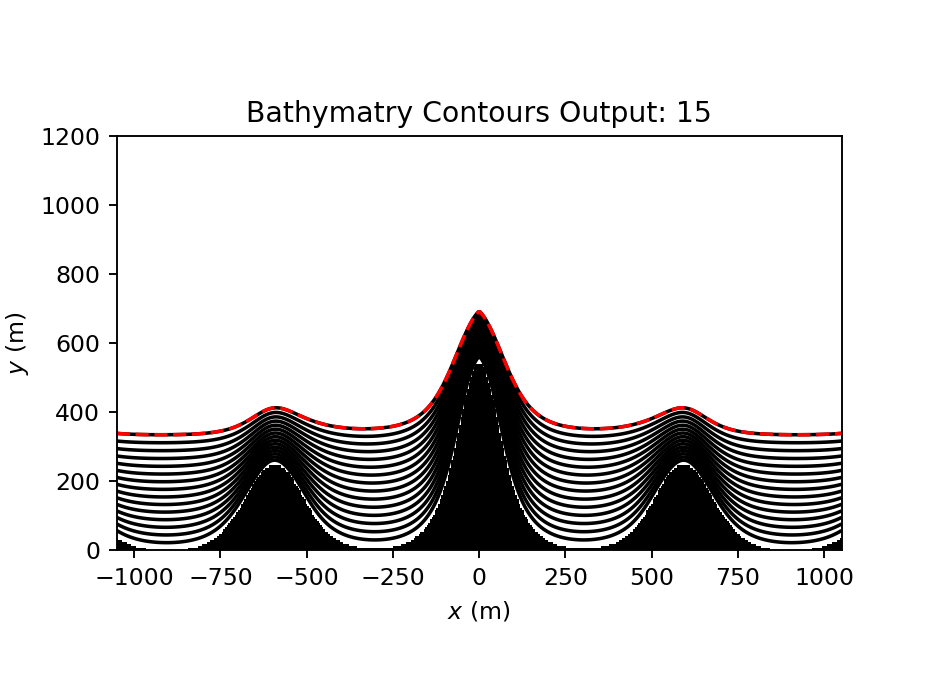

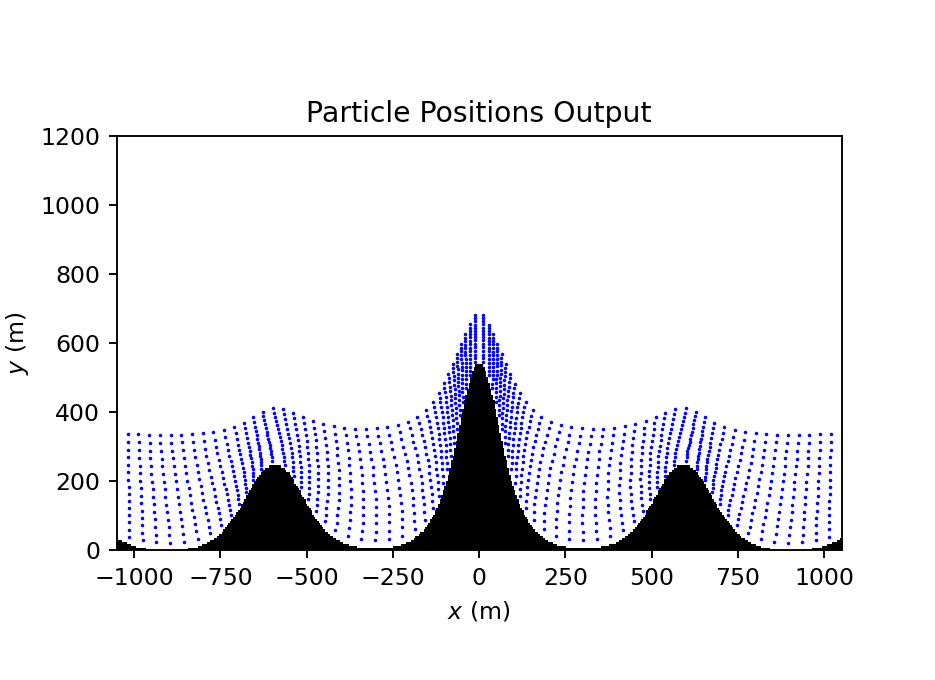

In [7]:
plt.close('all')
ncont = 15
X,Y = getContours(ds, ncont = ncont)
pointLists = getPoints(ds, X, Y, npart = 1200) 

## Compute Trajectories and Export File

In [8]:
ds["ubar_lagrangian"] = ds["ubar"] + ds["ubar_stokes"]
ds["vbar_lagrangian"] = ds["vbar"] + ds["vbar_stokes"]

In [9]:
x_psi,y_psi, = ds.x_psi, ds.y_psi
mesh = "flat"

velocities = {'U': 'ubar_lagrangian',
              'V': 'vbar_lagrangian'}

dimensions = {'U': {'lon': 'x_u', 'lat': 'y_u'},
              'V': {'lon': 'x_v', 'lat': 'y_v'}}

fieldset = FieldSet.from_xarray_dataset(ds, variables = velocities, dimensions = dimensions, mesh = mesh, 
                                        time_periodic = False,
                                        interp_method={
                                        "U": "freeslip",
                                        "V": "freeslip",
                                        },
                                       )


In [10]:
xpoints = pointLists[0]
ypoints = pointLists[1]

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

In [11]:
# parcels code to output a .zarr file of advected particle trajectories

# define lat and lon
pset = ParticleSet.from_list(fieldset = fieldset, pclass = JITParticle, time = ds.ocean_time.values, lon = xpoints, lat = ypoints)

# name output file, record dt for the output file separately from the model?
output_file = pset.ParticleFile(name = f"/Users/jordan/Documents/CICOES/data/posterData/1200p_{ncont}c_dt15", outputdt = timedelta(seconds = 30)) #, convert_at_end = True)

# use the standard advection kernel and our CheckOutOfBounds kernel above
kernels = AdvectionRK4 + pset.Kernel(CheckOutOfBounds)

# execute the advection over runtime with steps of size dt
pset.execute(kernels, runtime = timedelta(hours =  1), dt = timedelta(seconds = 15), output_file = output_file, verbose_progress = True)

INFO: Output files are stored in /Users/jordan/Documents/CICOES/data/posterData/1200p_15c_dt15.zarr.
100%|██████████| 3600.0/3600.0 [00:01<00:00, 1856.27it/s]


# POSTER - Contour Seeding/Bathymetry

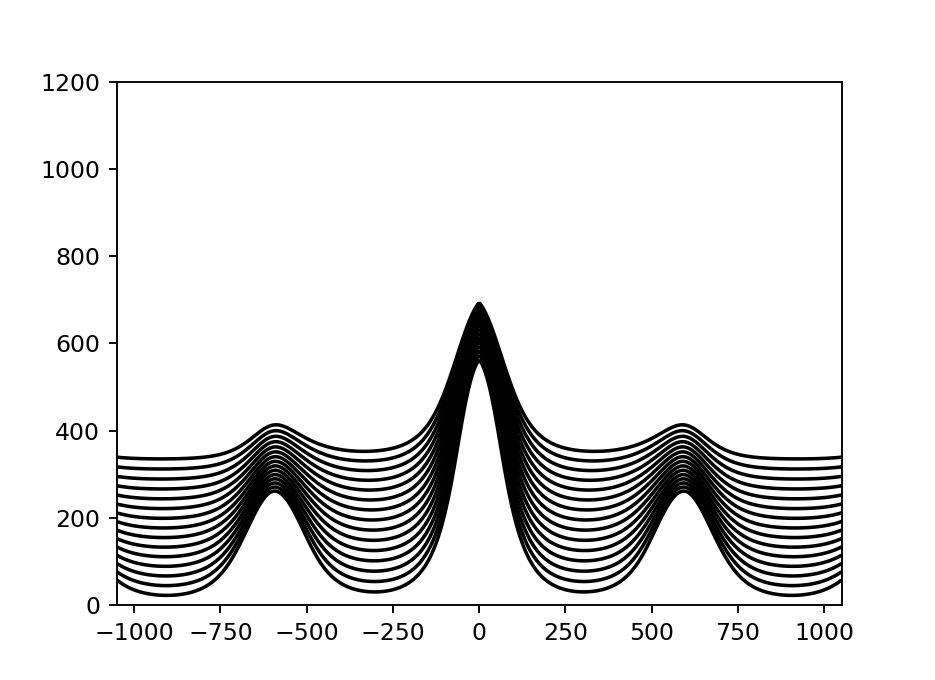

In [13]:
# plotting coordinates

# rho
x_rho = ds.x_rho[0,:].values 
y_rho = ds.y_rho[:,0].values
Xrho, Yrho = np.meshgrid(x_rho, y_rho)

# hard code levels
levels = np.linspace(1, 10, 15 + 1, endpoint = True)
levels = levels[1:]

# contour plot used in function
fig, ax = plt.subplots(figsize = (5.5,4), dpi = 170)

# create height contours
conts = ax.contour(Xrho, Yrho, ds['h'], levels = levels, colors = 'k')

In [14]:
# hard code contour plot -> list of points - just like above functions



npart = 1200

X = []; Y = []

for i in range(0, len(levels)) :

    # take the ith level, and get a list of x values and y values - see note above
    xi = conts.allsegs[i][0].T[0]
    yi = conts.allsegs[i][0].T[1]

    X.append(xi)
    Y.append(yi)

# empty lists for particle position coordinates
xvals = []; yvals = []

# loop through contours
for c in range(len(X)) :

    xc = X[c]
    yc = Y[c]

    # this code generates an array of distances between particles
    # start at 0 because the first point is the start of the contour, a distance 0 along it
    # S is defined as a distance coordinate along the contour.
    deltaS = [0]

    # loop through all particles (minus the first one)
    for p in range(len(xc) - 1) :
        deltaS.append( round(np.sqrt( (xc[p+1] - xc[p])**2 + (yc[p+1] - yc[p])**2), 3) )

    # this generates a cumulitive sum array, where each entry is the value S at point i
    Scumsum = np.cumsum(deltaS)

    # the number of contours is the number of separate arrays of positions in the array X
    ncont = len(X)
    
    # exclude the right endpoint, compute one more value than necesary so we can remove the left endpoint as well.
    # we don't want a particle at S = 0 or S = Scumsum[-1] because it would be on the edge of the screen.
    Svals = np.linspace(0, round(Scumsum[-1]), int(npart/ncont + 1), endpoint = False)
    Svals = Svals[1:]

    # interpolate the x and y values at our evenly spaced Svals
    xvalsc = np.interp(Svals, Scumsum, xc)
    yvalsc = np.interp(Svals, Scumsum, yc)

    # add our new points to our masterlists that will be returned
    xvals = np.concatenate([xvals, xvalsc])
    yvals = np.concatenate([yvals, yvalsc])
    



In [19]:
plt.close('all')
fig, ax = plt.subplots(figsize = (14,6.5), dpi = 100, constrained_layout = True)

# depth contour
# dep = ax.pcolormesh(Xrho, Yrho, ds['h'], vmin = 0, vmax = 20, cmap = cmocean.cm.haline_r, alpha = 0.5)

cs = ax.contour(Xrho, Yrho, ds['h'], levels = np.arange(1,20,2), colors = 'k')
ax.clabel(cs, np.arange(1,20,2))

# create height contours
# ax.contour(Xrho, Yrho, ds['h'], levels = levels, colors = 'k', linewidths = 0.5)

# plot seeded points
ax.scatter(xvals, yvals, s = 8, c = 'red')

# draws the land
ax.pcolormesh(ds.x_psi, ds.y_psi, np.ma.masked_where(ds.mask_psi == 1, ds.mask_psi), 
              cmap = colors.ListedColormap(['#FAF6EB', '#ffffff00']))

# ax.set_title('The Two Embayment System', size = 36, pad = 20)
ax.set_xlabel(r'$x$ (m)', size = 24)
ax.set_ylabel(r'$y$ (m)', size = 24)

ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)

ax.set_ylim(0,800)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")


# cbar = fig.colorbar(dep, orientation = "vertical", fraction = 0.05, aspect = 20, shrink = 0.675, pad = 0.01) # pad = 0.20
# cbar.set_label(label='Depth (m)', size=28) # can add weight = 'bold'
# cbar.ax.tick_params(labelsize = 24) #15

plt.savefig('plots/poster_video/seeding_test.png')
plt.close(fig)